In [2]:
# !pip install xclim 

In [15]:
# ! pip install cdsapi 

In [16]:
%matplotlib inline 
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os 
import gcsfs 
from matplotlib import cm
import warnings 

import cdsapi 

In [9]:
def read_gcs_zarr(zarr_url, token='/opt/gcsfuse_tokens/impactlab-data.json', check=False):
    """
    takes in a GCSFS zarr url, bucket token, and returns a dataset 
    Note that you will need to have the proper bucket authentication. 
    """
    fs = gcsfs.GCSFileSystem(token=token)
    
    store_path = fs.get_mapper(zarr_url, check=check)
    ds = xr.open_zarr(store_path)
    
    return ds 

In [10]:
pr_coarse_ref = read_gcs_zarr('gs://scratch-170cd6ec/91da8e47-b396-4360-b397-ece89f1b777e/e2e-miroc6-pr-8rn7f-2846959676/rechunked.zarr')

pr_fine_ref = read_gcs_zarr('gs://scratch-170cd6ec/91da8e47-b396-4360-b397-ece89f1b777e/e2e-miroc6-pr-8rn7f-587431548/rechunked.zarr')

pr_cleaned_ref = read_gcs_zarr('gs://clean-b1dbca25/reanalysis/ERA-5/F320/pr.1995-2015.F320.zarr')

pr_cleaned_ref_old = read_gcs_zarr('gs://scratch-170cd6ec/d56a0ccf-1c45-4d1e-9fd6-3264742c9f9c/e2e-pr-jobs-b2q9d-25364420/rechunked.zarr')

pr_raw_ref = read_gcs_zarr('gs://impactlab-data/climate/source_data/ERA-5/downscaling/pr.1994-2015.F320.v5.zarr')

In [11]:
# define Seattle lat/lon 
target_lat = 47.608013
target_lon = -122.335167

download some era-5 data. Note this won't work if you don't have credentials, so you'll have to go online to ECMWF and get them if you want to replicate this. Otherwise you can grab the file at this location on impactlab-data. 

In [12]:
filename = '/gcs/impactlab-data/climate/source_data/ERA-5/era5_pr_monthly_download_debug.nc'

In [17]:
c = cdsapi.Client()
# define small geographic area around Seattle 
c.retrieve(
    'reanalysis-era5-single-levels-monthly-means',
    {
        'format': 'netcdf',
        'product_type': 'monthly_averaged_reanalysis',
        'variable': 'total_precipitation',
        'year': [
            '2000', '2001', '2002',
            '2003', '2004', '2005',
            '2006', '2007', '2008',
            '2009', '2010',
        ],
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
        'time': '00:00',
        'area': [
            49, -124, 46,
            -121,
        ],
    },
    filename)

2022-01-05 00:47:23,170 INFO Welcome to the CDS
2022-01-05 00:47:23,171 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2022-01-05 00:47:53,305 WARNING Recovering from HTTP error [500 Internal Server Error], attemps 0 of 500
2022-01-05 00:47:53,306 WARNING Retrying in 120 seconds
2022-01-05 00:49:53,333 INFO Retrying now...
2022-01-05 00:49:54,379 INFO Request is completed
2022-01-05 00:49:54,380 INFO Downloading https://download-0014.copernicus-climate.eu/cache-compute-0014/cache/data0/adaptor.mars.internal-1641252783.3209045-5533-7-475d981e-8a4c-4a47-bd58-99361273a421.nc to /gcs/impactlab-data/climate/source_data/ERA-5/era5_pr_monthly_download_debug.nc (45.2K)
2022-01-05 00:49:55,759 INFO Download rate 32.8K/s  


Result(content_length=46316,content_type=application/x-netcdf,location=https://download-0014.copernicus-climate.eu/cache-compute-0014/cache/data0/adaptor.mars.internal-1641252783.3209045-5533-7-475d981e-8a4c-4a47-bd58-99361273a421.nc)

In [18]:
new_pr_monthly = xr.open_dataset(filename)

In [19]:
pr_seattle_pipeline = pr_cleaned_ref['pr'].sel(lon=target_lon, lat=target_lat, method="nearest").load()
pr_seattle_pipeline_coarse = pr_coarse_ref['pr'].sel(lon=target_lon, lat=target_lat, method="nearest").load()

In [20]:
pr_seattle_pipeline_fine = pr_fine_ref['pr'].sel(lon=target_lon, lat=target_lat, method="nearest").load()
pr_seattle_pipeline_raw = pr_raw_ref['tp'].sel(longitude=target_lon, latitude=target_lat, method="nearest").load()

In [21]:
pr_seattle_cds_mo_mean = new_pr_monthly['tp'].sel(longitude=target_lon, latitude=target_lat, method="nearest") * 1000

# ERA-5 data is monthly average of daily mean, so each month value is not a "monthly mean" but an avg daily value for that month 
pr_seattle_cds_mo_total = pr_seattle_cds_mo_mean * new_pr_monthly.time.dt.days_in_month

In [22]:
print(pr_coarse_ref['pr'].shape)
print(pr_fine_ref['pr'].shape)
print(pr_raw_ref['tp'].shape)
print(pr_cleaned_ref['pr'].shape)
print(new_pr_monthly['tp'].shape)

(8030, 720, 1440)
(8030, 720, 1440)
(8030, 640, 1280)
(8030, 640, 1280)
(132, 13, 13)


Text(0.5, 1.0, 'Seattle annual precip')

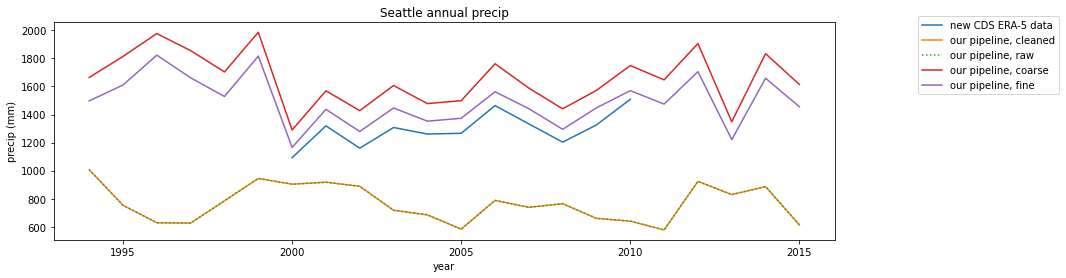

In [23]:
plt.figure(figsize=(14, 4))
pr_seattle_cds_mo_total.groupby('time.year').sum().plot(label='new CDS ERA-5 data')

pr_seattle_pipeline.groupby('time.year').sum().plot(label='our pipeline, cleaned')

pr_seattle_pipeline.groupby('time.year').sum().plot(label='our pipeline, raw', linestyle=':')

pr_seattle_pipeline_coarse.groupby('time.year').sum().plot(label='our pipeline, coarse')

pr_seattle_pipeline_fine.groupby('time.year').sum().plot(label='our pipeline, fine')

plt.legend(bbox_to_anchor=(1.1, 1.05))

plt.ylabel('precip (mm)')
plt.title('Seattle annual precip')